In [4]:
import numpy as np
import random
import matplotlib.pyplot as plt
from proofreader.utils.io import read_cremi_volume, from_h5
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
import matplotlib.pyplot as plt
import IPython

def view_volume(volume, fig_size=6.5):
    length = volume.shape[0]

    # set up
    fig = plt.figure()
    fig.set_size_inches(fig_size, fig_size)
    axes = fig.add_subplot()
    hfig = display(fig, display_id=True)

    # display
    for i in range(length):
        axes.imshow(volume[i], cmap='gray', interpolation='none',
                    filternorm=False, resample=False)
        fig.canvas.draw()
        hfig.update(fig)
        if i != length-1:
            plt.cla()
    # clean up
    IPython.display.clear_output()


In [ ]:
import random
import cc3d
from proofreader.utils.all import list_remove, split_int
from proofreader.utils.data import arg_where_range, circular_mask, crop_where
from proofreader.utils.vis import view_segmentation, grid_volume
from skimage.color import label2rgb
from skimage.segmentation import find_boundaries

# c:int, label of a neurite in vol to use as source
# example_type:bool True for positive example, False for negative example
# radius:int radius (voxels) on bottom cross section in which to select second neurite
# num_slices:int number of slices to drop
# context_slices:int  max number of slice on top and bottom neurites
def example_from_class(vol, c, example_type, num_slices, radius, context_slices = 10):

    margin = 1 # number of slices that must be left on top after droping slices
    top_c = c
    (sz, sy, sx) = vol.shape

    # Find min and max z slice on which c occurs #
    for i in range(sz):
        if c in vol[i]:
            zmin = i
            break
    for i in reversed(range(sz)):
        if c in vol[i]:
            zmax = i
            break
    assert zmax - zmin >= num_slices + 2 , f'zspan of neurite must be at least 2 slices bigger than num_slices to drop, zspan:{zmax - zmin}, num_slices:{num_slices}'
    # the drop can start at the end of the top nerutie for negative examples
    # but should start earlier such that there is some bottom fragment for postive examples
    z_max_range = zmax-margin-num_slices+1 if example_type else zmax+1
    drop_start = random.randint(zmin+margin, z_max_range) # margin not needed on bottom
    drop_end = min(drop_start+num_slices, vol.shape[0]) # take min to ensure there is some bottom vol
    top_z_len = min(context_slices, drop_start-zmin) 
    bot_z_len = min(context_slices, sz-drop_end) 
    
    # Alloc final vol, we dont know how large it will be in y and x but we know max z #
    mz = num_slices + top_z_len + bot_z_len
    final_vol = np.zeros((mz, sy, sx), dtype='uint')

    # Build top section #
    top_vol_section = final_vol[0:top_z_len]
    top_vol_section[vol[drop_start-top_z_len:drop_start] == top_c] = top_c

    # Do connected component relabeling to ensure only one fragment on top #
    top_vol_section_relabeled = cc3d.connected_components(top_vol_section)
    top_classes_relabeled = list(np.unique(top_vol_section_relabeled[-1])) # must select from top border slice
    top_classes_relabeled = list_remove(top_classes_relabeled, 0)
    relabeled_top_c = random.choice(top_classes_relabeled) # select new top class from relabeled top section
    top_vol_section_relabeled[top_vol_section_relabeled != relabeled_top_c] = 0

    # Get midpoint of neurite on 2D top cross section, #
    top_border = top_vol_section_relabeled[-1]
    mins, maxs = arg_where_range(top_border == relabeled_top_c) # use the relabeled top section
    mp_y, mp_x = [(mi+ma)//2 for mi,ma in zip(mins,maxs)] # midpoint

    # Find all neurites with distnce D from that point on bottom cross section #
    bot_border = vol[drop_end].copy() # need copy because we zero
    mask = circular_mask(bot_border.shape[0], bot_border.shape[1], center=(mp_x, mp_y), radius=radius)
    bot_border[~mask] = 0
    mismatch_classes = list(np.unique(bot_border))

    # For positive examples, simply set bottom class to top class #
    if example_type:
        bot_c = top_c
    else:
    # Other wise select bottom class by picking 1 neurite from set of labels in radius #
        assert mismatch_classes[0] == 0, 'first class should be 0, otherwise something went wrong'
        mismatch_classes = list_remove(mismatch_classes, [0, top_c]) # remove 0 and top class lables
        if len(mismatch_classes) == 0:
            print(f'for {example_type} example, could not find bottom label within radius, returning none')
            return None
        # maybe could select here based on on cross-sectional volume
        bot_c = random.choice(mismatch_classes) # select bottom neurite class

    print('top_c, bot_c', top_c, bot_c)

    # Build bot section #
    bot_vol_section = final_vol[num_slices+top_z_len:]
    bot_vol_section[vol[drop_end:drop_end+bot_z_len] == bot_c] = bot_c

    # Do connected component relabeling to ensure only one fragment on bottom #
    # The mask and radius are needed for both positive and negative examples #
    # So that after connected components we can pick a fragment near the top neurite #
    bot_vol_section_relabeled = cc3d.connected_components(bot_vol_section)
    bot_border_relabled = bot_vol_section_relabeled[0]
    relabeled_fragments_in_radius = list(np.unique(bot_border_relabled[mask]))
    relabeled_fragments_in_radius = list_remove(relabeled_fragments_in_radius, 0)
    if len(relabeled_fragments_in_radius) == 0:
        print(f'for {example_type} example, could not find bottom label within radius, returning none')
        return None
    relabeled_bot_c = random.choice(relabeled_fragments_in_radius) # take fragment which is in radius
    bot_vol_section_relabeled[bot_vol_section_relabeled != relabeled_bot_c] = 0


    # Build final volume of top and bottom sections #
    final_vol[0:top_z_len] = top_vol_section_relabeled
    final_vol[num_slices+top_z_len:] = bot_vol_section_relabeled
    
    # Take surfaces of vols and final connected components sanity check #
    # final_vol = find_boundaries(final_vol, mode='inner').astype(np.uint8)
    # final_vol = cc3d.connected_components(final_vol)
    # assert len(np.unique(final_vol)) == 3, 'final sample should have 3 labels, n1, n2, 0'

    return final_vol


In [ ]:
def least_sq(data):
    # Calculate the mean of the points, i.e. the 'center' of the cloud
    datamean = data.mean(axis=0)

    # Do an SVD on the mean-centered data.
    uu, dd, vv = np.linalg.svd(data - datamean)

    # Now vv[0] contains the first principal component, i.e. the direction
    # vector of the 'best fit' line in the least squares sense.

    unit = vv[0]
    intercept = datamean
    return unit, intercept

def least_sq_solve_for_z(vec,off,z):
    s = (z - off[0]) / vec[0]
    return vec*s + off


In [ ]:
from proofreader.utils.all import clamp

def test_success(vol, c, num_slices, radius, inter_slices, context_slices=10):

    margin = 1 # number of slices that must be left on top after droping slices
    top_c = c
    (sz, sy, sx) = vol.shape
    all_res = {}

    # Find min and max z slice on which c occurs #
    for i in range(sz):
        if c in vol[i]:
            zmin = i
            break
    for i in reversed(range(sz)):
        if c in vol[i]:
            zmax = i
            break
    assert zmax - zmin >= num_slices + 2 , f'zspan of neurite must be at least 2 slices bigger than num_slices to drop, zspan:{zmax - zmin}, num_slices:{num_slices}'
    # the drop can start at the end of the top nerutie for negative examples
    # but should start earlier such that there is some bottom fragment for postive examples
    z_max_range = zmax-margin-num_slices+1
    drop_start = random.randint(zmin+margin, z_max_range) # margin not needed on bottom
    drop_end = min(drop_start+num_slices, vol.shape[0]) # take min to ensure there is some bottom vol
    top_z_len = min(context_slices, drop_start-zmin) 
    bot_z_len = min(context_slices, sz-drop_end) 

    # Alloc final vol, we dont know how large it will be in y and x but we know max z #
    mz = num_slices + top_z_len + bot_z_len
    final_vol = np.zeros((mz, sy, sx), dtype='uint')

    # Build top section #
    top_vol_section = final_vol[0:top_z_len]
    top_vol_section[vol[drop_start-top_z_len:drop_start] == top_c] = top_c

    # Do connected component relabeling to ensure only one fragment on top #
    top_vol_section_relabeled = cc3d.connected_components(top_vol_section)
    top_classes_relabeled = list(np.unique(top_vol_section_relabeled[-1])) # must select from top border slice
    top_classes_relabeled = list_remove(top_classes_relabeled, 0)

    if len(top_classes_relabeled) == 0:
        print('encountered error, dumping')
        print('zmin, zmax: ', zmin, zmax)
        print('top_c', top_c)
        print('drop range: ', drop_start, drop_end )
        print('top, bot z_len: ', top_z_len, bot_z_len )

    relabeled_top_c = random.choice(top_classes_relabeled) # select new top class from relabeled top section
    top_vol_section_relabeled[top_vol_section_relabeled != relabeled_top_c] = 0

    def assess_method(method_bot_border, method=''):
        # view_segmentation([bot_border])
        bot_classes, counts = get_classes_sorted_by_volume(method_bot_border, reverse=True, return_counts=True)
        if len(bot_classes) == 1:
            print('encountered error, dumping')
            print(method)
            # print('mins, maxs', arg_where_range(vol==top_c))
            print('top_c', top_c)
            print('drop range: ', drop_start, drop_end )
            print('top, bot z_len: ', top_z_len, bot_z_len )

        assert bot_classes[0] == 0, 'most numerous should be zero'
        bot_classes, counts = bot_classes[1:], counts[1:]
        
        # does the true neurite occur?
        true_occur = top_c in bot_classes
        # how many total classes occur?
        num_classes = len(bot_classes)
        # percent vol of true
        if true_occur:
            vol = counts[top_c == bot_classes]
            total = np.sum(counts)
            percent = vol / total
            percent = percent[0]
            is_max = top_c == bot_classes[np.argmax(counts)]
        else:
            is_max = False
            percent = 0
        return true_occur, num_classes, is_max, percent 

    #############
    ## METHODS ##
    #############

    ## PROJECT ACROSS THEN L2 RADIUS ##
    # Get midpoint of neurite on 2D top cross section, #
    top_border = top_vol_section_relabeled[-1]
    mins, maxs = arg_where_range(top_border == relabeled_top_c) # use the relabeled top section
    mp_y, mp_x = [(mi+ma)//2 for mi,ma in zip(mins,maxs)] # midpoint

    # Find all neurites with distnce D from that point on bottom cross section #
    bot_border = vol[drop_end].copy() # need copy because we zero
    mask = circular_mask(bot_border.shape[0], bot_border.shape[1], center=(mp_x, mp_y), radius=radius)
    bot_border[~mask] = 0
    res = assess_method(bot_border, method='MIDPOINT_RADIUS')
    all_res['MIDPOINT_RADIUS'] = res

    ## APPLY CROSS-SECTION ACROSS ##
    bot_border = vol[drop_end].copy()
    bot_border[top_border != relabeled_top_c] = 0

    res = assess_method(bot_border, method='MIDPOINT_CROSS-SECTION')
    all_res['MIDPOINT_CROSS-SECTION'] = res

    ## INTERPOLATE MP THEN RADIUS ##
    # we need to do crop_where again in case we lost some during connected component
    mins, maxs = arg_where_range(top_vol_section_relabeled == relabeled_top_c) 
    num_points = min(inter_slices,maxs[0]-mins[0]+1)
    midpoints = []
    for i in range(num_points):
        section = top_vol_section_relabeled[-(i+1)]
        mins, maxs = arg_where_range(section == relabeled_top_c) # use the relabeled top section
        mp_y, mp_x = [(mi+ma)//2 for mi,ma in zip(mins,maxs)] # midpoint
        midpoints.append([drop_start-i-1, mp_y, mp_x])


    midpts = np.array(midpoints)
    vec, off = least_sq(midpts)
    (proj_z, proj_y, proj_x) = least_sq_solve_for_z(vec, off, drop_end)
    proj_y, proj_x = int(clamp(proj_y, 0, sy)), int(clamp(proj_x, 0, sx))

    # Find all neurites with distnce D from that point on bottom cross section #
    bot_border = vol[drop_end].copy() # need copy because we zero
    mask = circular_mask(bot_border.shape[0], bot_border.shape[1], center=(proj_x, proj_y), radius=radius)
    bot_border[~mask] = 0

    res = assess_method(bot_border, method='INTERPOLATE_RADIUS')
    all_res['INTERPOLATE_RADIUS'] = res


    ## INTERPOLATE MP THEN CROSS-SECTION ##
    midpoints = []
    for i in range(num_points):
        section = top_vol_section_relabeled[-(i+1)]
        mins, maxs = arg_where_range(section == relabeled_top_c) # use the relabeled top section
        mp_y, mp_x = [(mi+ma)//2 for mi,ma in zip(mins,maxs)] # midpoint
        midpoints.append([drop_start-i-1, mp_y, mp_x])


    midpts = np.array(midpoints)
    vec, off = least_sq(midpts)
    (proj_z, proj_y, proj_x) = least_sq_solve_for_z(vec, off, drop_end)
    proj_y, proj_x = int(clamp(proj_y, 0, sy)), int(clamp(proj_x, 0, sx))

    top_border = top_vol_section_relabeled[-1]
    bot_border = vol[drop_end].copy() # need copy because we zero
    mins, maxs = arg_where_range(top_border == relabeled_top_c) # use the relabeled top section
    top_border = crop_where(top_border, top_border == relabeled_top_c)
    shift_y_a, shift_y_b = split_int(maxs[0]-mins[0]+1)
    shift_x_a, shift_x_b = split_int(maxs[1]-mins[1]+1)
    x_a, x_b = proj_x-shift_x_a, proj_x+shift_x_b
    y_a, y_b = proj_y-shift_y_a, proj_y+shift_y_b
    if x_a < 0:
        top_border = top_border[:, -1*x_a:]
        x_a = 0
    if y_a < 0:
        top_border = top_border[-1*y_a:]
        y_a = 0
    if x_b > sx:
        top_border = top_border[:, :-1*(x_b-sx)]
        x_b = sx
    if y_b > sy:
        top_border = top_border[:-1*(y_b-sy)]
        y_b = sy

    bot_border_sec = bot_border[y_a:y_b, x_a:x_b]
    bot_border[:y_a] = 0
    bot_border[:,:x_a] = 0
    bot_border[y_b:] = 0
    bot_border[:,x_b:] = 0
    bot_border_sec[top_border != relabeled_top_c] = 0

    res = assess_method(bot_border, method='INTERPOLATE_CROSS-SECTION')
    all_res['INTERPOLATE_CROSS-SECTION'] = res


    return all_res

In [ ]:
vol = trueC.copy()

In [ ]:
num_slices = 3
classes_z = get_classes_which_zspan_at_least(vol, num_slices+2)
classes_vol = get_classes_with_at_least_volume(vol, 400)
classes = list(set(classes_z) & set(classes_vol))
print(f'{len(classes)}/{len(np.unique(vol))}')

In [ ]:
from pprint import pprint

init = {'total_occur':0, 'avg_classes_when_occur':0, 'total_max':0, 'avg_percent_when_occur':0 }
classes = list(classes)
random.shuffle(classes)
number_examples = min(500,len(classes))
radius = 64
inter_slices = 2
all_total = {}
for i in range(number_examples):
    c = classes[i]  
    all_res = test_success(vol, c, num_slices=num_slices, radius=radius, inter_slices=inter_slices)

    for key, value in all_res.items(): 
        true_occur, num_classes, is_max, percent  = value
        if i == 0:
            all_total[key] = init.copy()
        totals = all_total[key]
        if true_occur:
            totals['total_occur'] += 1
            totals['avg_classes_when_occur'] += num_classes
            totals['avg_percent_when_occur'] += percent
        if is_max:
            totals['total_max'] += 1
    
    print('.', end='')

for key, value in all_res.items(): 
    totals = all_total[key]
    totals['avg_classes_when_occur'] /= totals['total_occur'] 
    totals['avg_percent_when_occur'] /= totals['total_occur'] 
    totals['avg_occur'] = totals['total_occur'] / number_examples
    totals['avg_max'] = totals['total_max']  / number_examples

print(f'\nnum slices: {num_slices} num examples: {number_examples}, radius {radius}, inter_slices {inter_slices}')
pprint(all_total)

In [6]:
from proofreader.data.cremi import prepare_cremi_vols

train_vols, val_vols = prepare_cremi_vols('../../dataset/cremi')

In [7]:
from proofreader.data.splitter import SplitterDataset

num_slices = [1, 4]
radius = 96
context_slices = 8

dataset = SplitterDataset(train_vols, num_slices, radius, context_slices, num_points==1024, open_vol=True, return_vol=True, verbose=True)
print(len(dataset))

3534


False (1024, 3) (13, 107, 222)


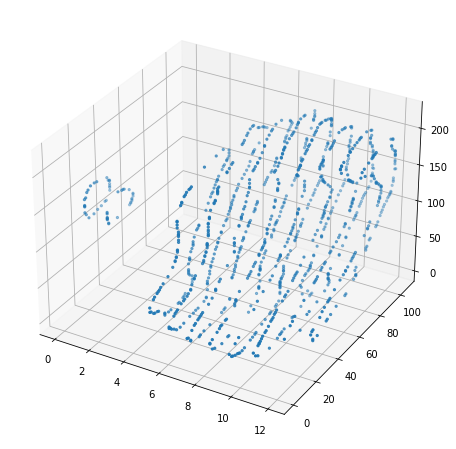

True (1024, 3) (8, 123, 214)


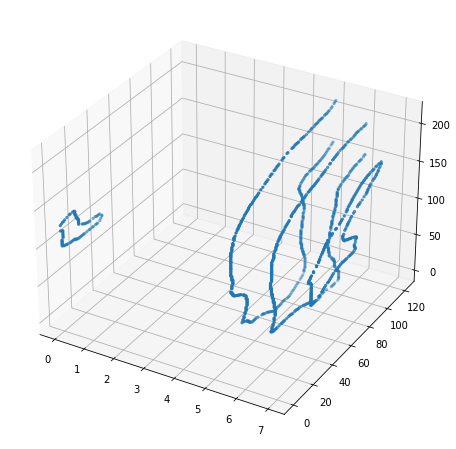

True (1024, 3) (17, 130, 114)


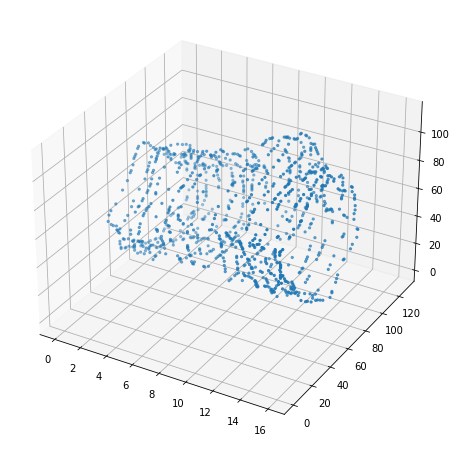

True (1024, 3) (15, 263, 179)


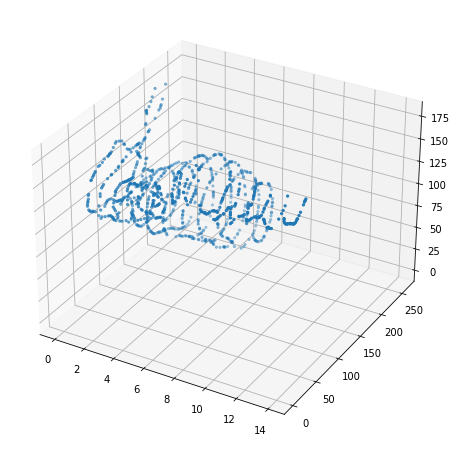

False (1024, 3) (20, 311, 489)


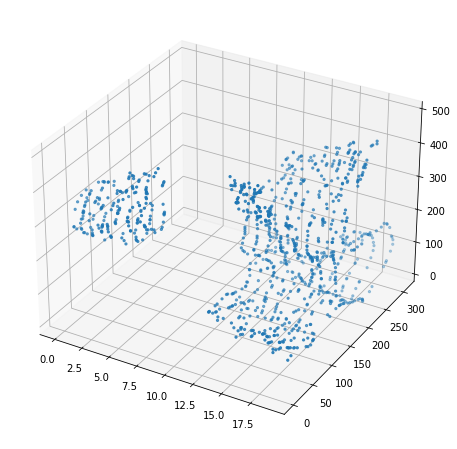

not enough points, need 1024, have 286, replace sampling to fix
False (1024, 3) (8, 72, 74)


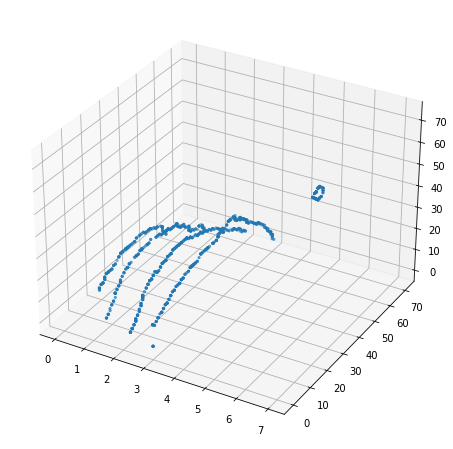

False (1024, 3) (18, 392, 254)


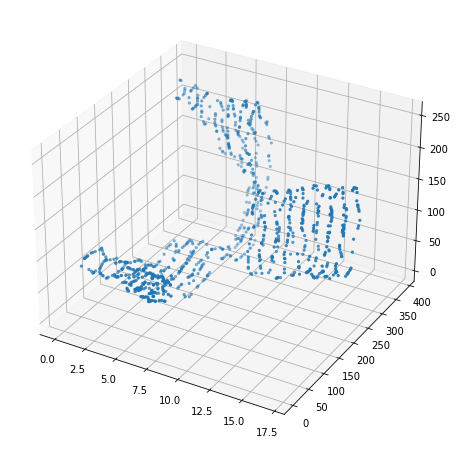

(relabel bot) for True example, class 816, cut (64, 65), could not find bottom label within radius, returning none
redo on i 623
False (1024, 3) (20, 246, 201)


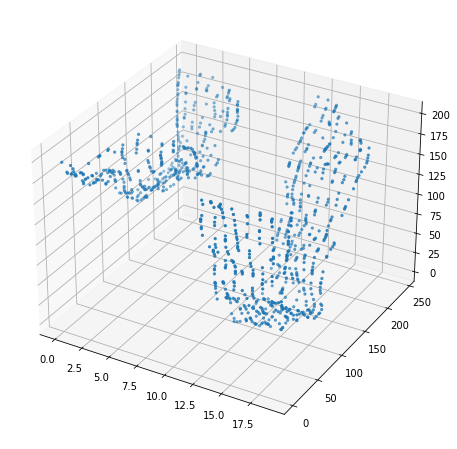

not enough points, need 1024, have 222, replace sampling to fix
False (1024, 3) (10, 54, 23)


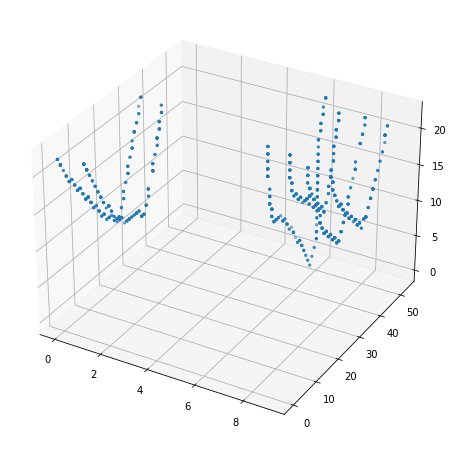

not enough points, need 1024, have 838, replace sampling to fix
True (1024, 3) (13, 84, 72)


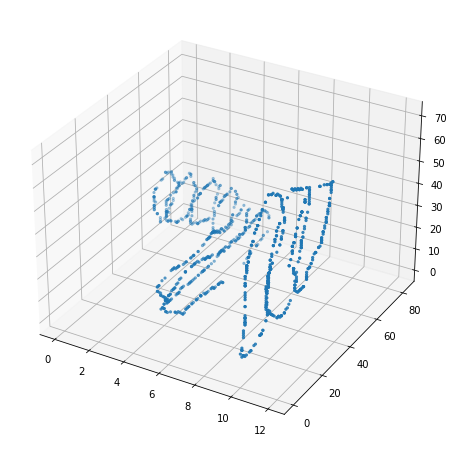

False (1024, 3) (18, 87, 241)


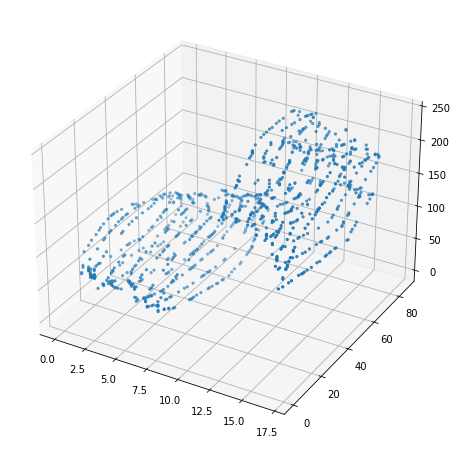

True (1024, 3) (14, 207, 169)


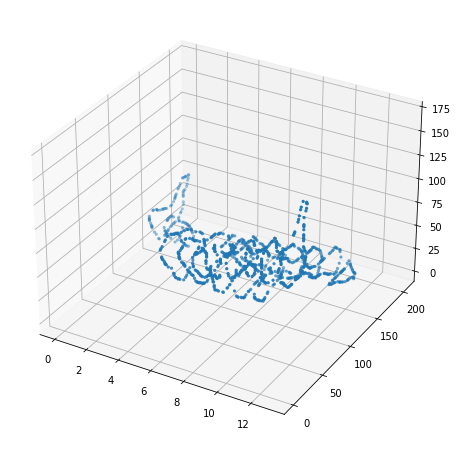

False (1024, 3) (17, 241, 246)


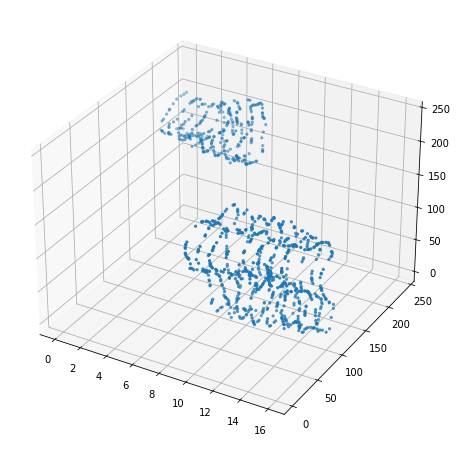

KeyboardInterrupt: 

In [16]:
from proofreader.utils.vis import plot_3d
num = 100
for i in range(0, num):
    rand_i = random.randint(0, len(dataset))
    pc, vol, label = dataset[rand_i]
    print(f'{label} {pc.shape} {vol.shape}')
    plot_3d(pc)

